In [1]:
!pip install imbalanced-learn

In [2]:
#Load neccesary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, RocCurveDisplay, recall_score,
    make_scorer, fbeta_score
)


pd.set_option('display.max_columns', None)
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('final_dataset.csv')

# Training Logistic

In [4]:
print(df.shape)
df.head()

(995343, 38)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month,intended_balcon_missing,bank_months_missing,velocity_6h_missing,income_age_ratio,income_credit_risk_ratio,credit_risk_age_ratio,income_group
0,0,0.3,0.986506,0,25.0,40,0.006735,102.453711,AA,1059,13096.035018,7850.955007,6742.080561,5,5,CB,163,1,BC,0,1,9,0,1500.0,0,INTERNET,16.224843,linux,1,1.0,0,0,0,0,0.0075,0.001840,4.075,low
1,0,0.8,0.617426,0,89.0,20,0.010095,32.433701,AD,1658,9223.283431,5745.251481,5941.664859,3,18,CA,154,1,BC,1,1,2,0,1500.0,0,INTERNET,3.363854,other,1,1.0,0,1,0,0,0.0400,0.005195,7.700,high
2,0,0.8,0.996707,9,14.0,40,0.012316,32.433701,AB,1095,4471.472149,5471.988958,5992.555113,15,11,CA,89,1,BC,0,1,30,0,200.0,0,INTERNET,22.730559,windows,0,1.0,0,1,0,0,0.0200,0.008989,2.225,high
3,0,0.6,0.475100,11,14.0,30,0.006991,32.433701,AB,3483,14431.993621,6755.344479,5970.336831,11,13,CA,90,1,BC,0,1,1,0,200.0,0,INTERNET,15.215816,linux,1,1.0,0,1,0,0,0.0200,0.006667,3.000,high
4,0,0.9,0.842307,0,29.0,40,5.742626,47.152498,AA,2339,7601.511579,5124.046930,5940.734212,1,6,CA,91,0,BC,1,1,26,0,200.0,0,INTERNET,3.743048,other,0,1.0,0,0,0,0,0.0225,0.009890,2.275,high


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995343 entries, 0 to 995342
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   fraud_bool                        995343 non-null  int64  
 1   income                            995343 non-null  float64
 2   name_email_similarity             995343 non-null  float64
 3   prev_address_months_count         995343 non-null  int64  
 4   current_address_months_count      995343 non-null  float64
 5   customer_age                      995343 non-null  int64  
 6   days_since_request                995343 non-null  float64
 7   intended_balcon_amount            995343 non-null  float64
 8   payment_type                      995343 non-null  object 
 9   zip_count_4w                      995343 non-null  int64  
 10  velocity_6h                       995343 non-null  float64
 11  velocity_24h                      995343 non-null  f

In [6]:
#one-hot encoding categorical columns
categorical_cols = ['payment_type','employment_status','housing_status','source','device_os','income_group']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


<Axes: >

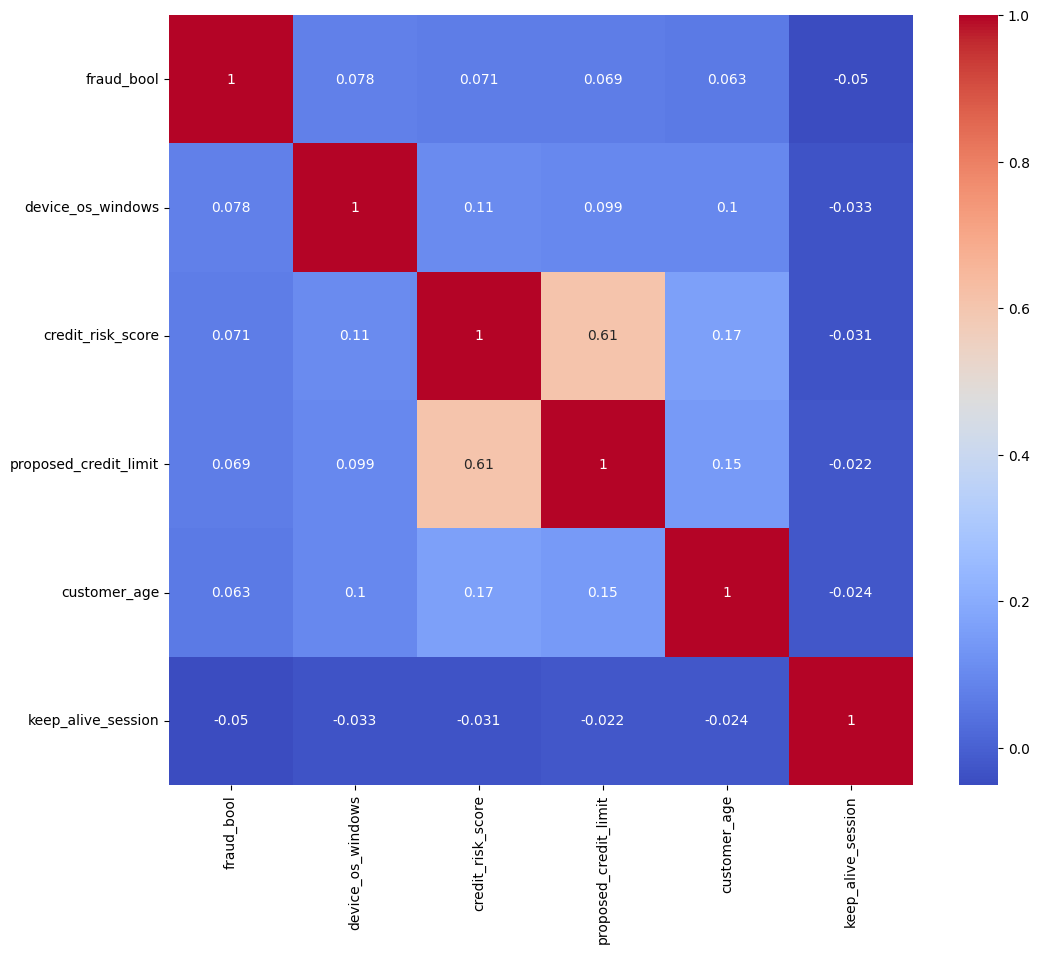

In [7]:
# draw correlation matrix
plt.figure(figsize=(12,10))
target_corr = df.corr()['fraud_bool'].sort_values(ascending=False)
sns.heatmap(df[target_corr[abs(target_corr) > 0.05].index].corr(), annot=True, cmap='coolwarm')

# Resampling

In [8]:
#train test split
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

objective_col = 'fraud_bool'
X = df.drop(objective_col, axis=1)
y = df[objective_col]

# training - testing is 70% - 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

#Undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

In [9]:
X_train_balanced.shape

(15408, 54)

In [10]:
y_train_balanced.shape

(15408,)

# Logictic Regression (Base Model)

In [11]:
results_df = pd.DataFrame()

Base Logistic Regression Model
Recall at 1 (Test): 0.7840702604482132

=== Base Logistic Regression Evaluation ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    295145
           1       0.04      0.78      0.08      3302

    accuracy                           0.80    298447
   macro avg       0.52      0.79      0.49    298447
weighted avg       0.99      0.80      0.88    298447

Confusion Matrix:
 [[236934  58211]
 [   713   2589]]
Accuracy: 0.8025646094616464
ROC-AUC Score: 0.8719186184897221


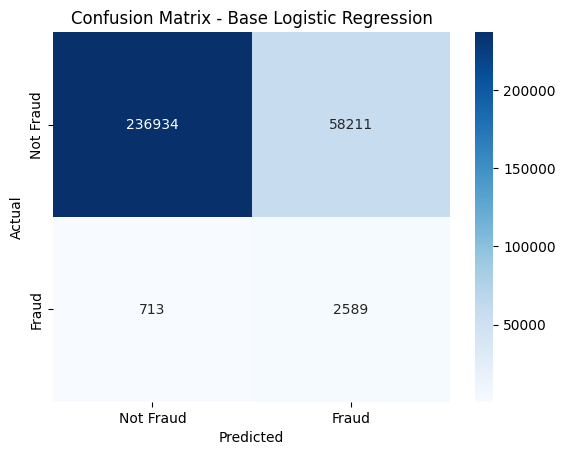

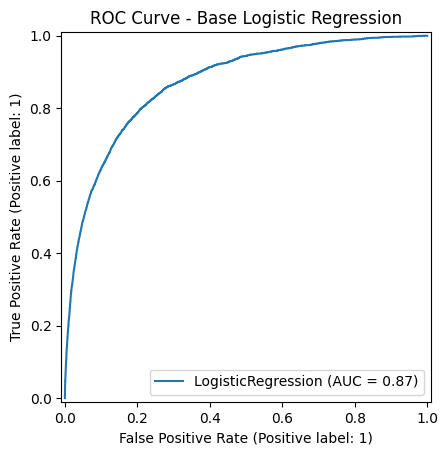

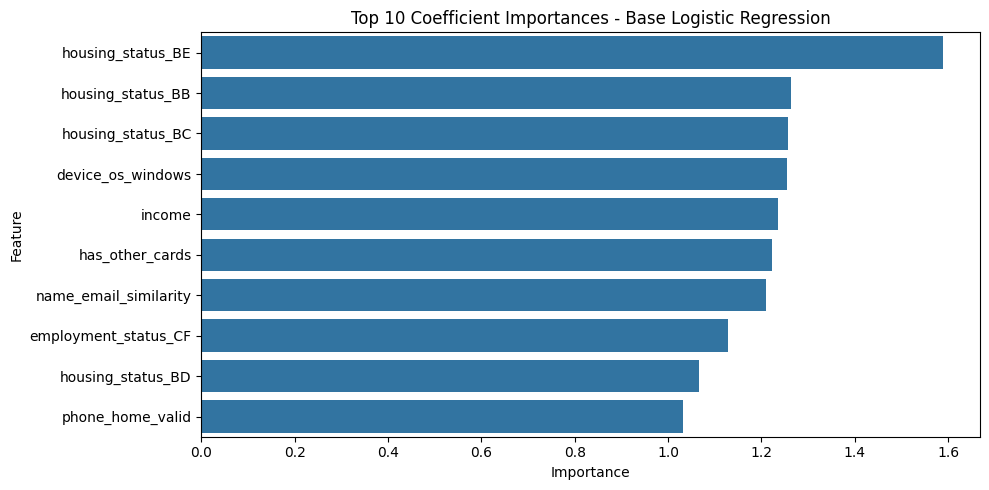

In [12]:

# Define base Logistic Regression model
logreg_base = LogisticRegression(
    solver='liblinear',  # 'liblinear' works well for small datasets and binary tasks
    random_state=42
)
logreg_base.fit(X_train_balanced, y_train_balanced)

# Predict on test data
y_pred_logreg_base = logreg_base.predict(X_test)
y_proba_logreg_base = logreg_base.predict_proba(X_test)[:, 1]

# Evaluation metrics
base_recall_at_1 = recall_score(y_test, y_pred_logreg_base)

print("Base Logistic Regression Model")
print("Recall at 1 (Test):", base_recall_at_1)
print("\n=== Base Logistic Regression Evaluation ===")
print("Classification Report:\n", classification_report(y_test, y_pred_logreg_base))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg_base))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_base))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_logreg_base))

# Confusion Matrix Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_logreg_base), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - Base Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(logreg_base, X_test, y_test)
plt.title("ROC Curve - Base Logistic Regression")
plt.show()

# Feature Importance (Top 10)
importance_base = np.abs(logreg_base.coef_[0])
importance_base_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': importance_base})
importance_base_df.sort_values('Importance', ascending=False, inplace=True)

top_n = 10
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_base_df.head(top_n))
plt.title(f"Top {top_n} Coefficient Importances - Base Logistic Regression")
plt.tight_layout()
plt.show()

# Save results to results_df
results_df = pd.concat([
    results_df,
    pd.DataFrame({
        'Model': ['Base Logistic Regression'],
        'Best Parameters': ['-'],
        'Best ROC AUC': ['-'],
        'Best Recall at 1': [base_recall_at_1]
    })
], ignore_index=True)

## Testing with different threshold

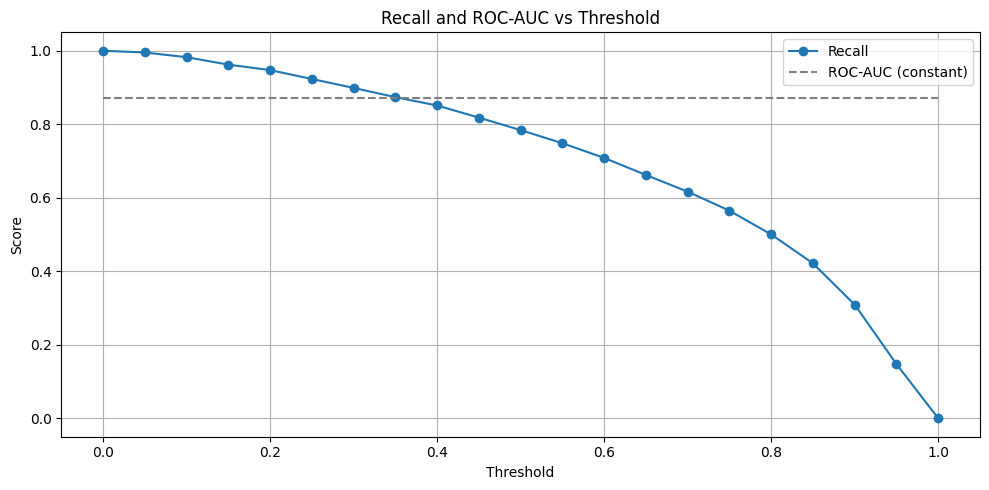

In [13]:
# Threshold evaluation
thresholds = np.arange(0.0, 1.05, 0.05)
recalls = []
roc_aucs = []

for thresh in thresholds:
    y_pred_thresh = (y_proba_logreg_base >= thresh).astype(int)
    recalls.append(recall_score(y_test, y_pred_thresh))
    roc_aucs.append(roc_auc_score(y_test, y_proba_logreg_base))  # same for all thresholds

# Plot Recall vs Threshold
plt.figure(figsize=(10, 5))
plt.plot(thresholds, recalls, marker='o', label='Recall')
plt.plot(thresholds, roc_aucs, linestyle='--', color='gray', label='ROC-AUC (constant)')
plt.title("Recall and ROC-AUC vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Lasso Regularisation

Fitting 5 folds for each of 15 candidates, totalling 75 fits
 Best Parameters (L1 Logistic Regression): {'C': 1, 'max_iter': 1000}
 Best Recall at 1 (Test): 0.7852816474863719

=== Tuned L1 Logistic Regression Evaluation ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    295145
           1       0.04      0.79      0.08      3302

    accuracy                           0.80    298447
   macro avg       0.52      0.79      0.49    298447
weighted avg       0.99      0.80      0.88    298447

Confusion Matrix:
 [[237427  57718]
 [   709   2593]]
Accuracy: 0.8042298967655899
ROC-AUC Score: 0.8722475649974385


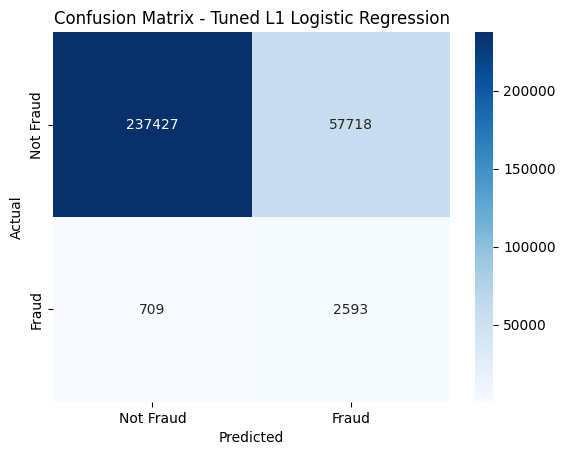

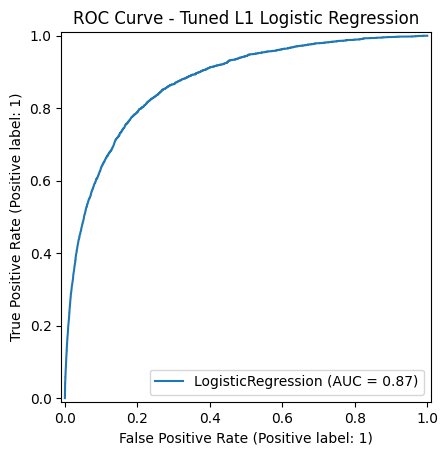

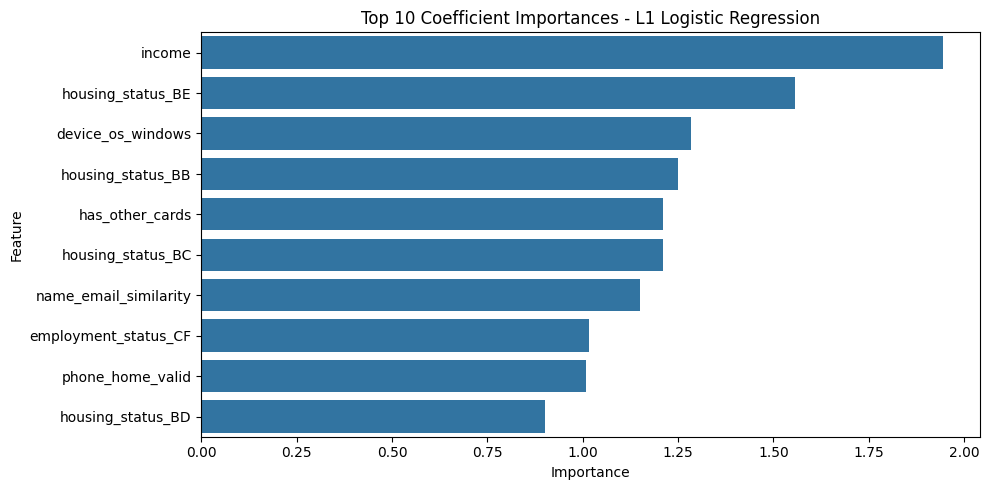

In [14]:


# Define L1 Logistic Regression model
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)

# Hyperparameter grid for L1
param_grid_logreg_l1 = {
    'C': [0.01,0.05, 0.1, 1, 10],
    'max_iter': [1000, 2000, 3000]
}

# Cross-validation setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# Grid Search for L1 Logistic Regression
grid_logreg_l1 = GridSearchCV(
    estimator=logreg_l1,
    param_grid=param_grid_logreg_l1,
    scoring='recall',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

grid_logreg_l1.fit(X_train_balanced, y_train_balanced)

# Save best model
best_logreg_l1 = grid_logreg_l1.best_estimator_

# Save tuning results
logreg_l1_best_params = grid_logreg_l1.best_params_
logreg_l1_best_auc_roc = roc_auc_score(y_test, best_logreg_l1.predict_proba(X_test)[:, 1])
logreg_l1_best_recall_at_1 = recall_score(y_test, best_logreg_l1.predict(X_test))

print(" Best Parameters (L1 Logistic Regression):", logreg_l1_best_params)
print(" Best Recall at 1 (Test):", logreg_l1_best_recall_at_1)

# Evaluate on test set
y_pred_logreg_l1 = best_logreg_l1.predict(X_test)
y_proba_logreg_l1 = best_logreg_l1.predict_proba(X_test)[:, 1]

print("\n=== Tuned L1 Logistic Regression Evaluation ===")
print("Classification Report:\n", classification_report(y_test, y_pred_logreg_l1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg_l1))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_l1))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_logreg_l1))

# Confusion Matrix Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_logreg_l1), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - Tuned L1 Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_logreg_l1, X_test, y_test)
plt.title("ROC Curve - Tuned L1 Logistic Regression")
plt.show()

# Feature Importance (Top 10)
importance_logreg_l1 = np.abs(best_logreg_l1.coef_[0])
importance_l1_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': importance_logreg_l1})
importance_l1_df = importance_l1_df[importance_l1_df['Importance'] > 0]  # Remove zeroed coefficients
importance_l1_df.sort_values('Importance', ascending=False, inplace=True)

top_n = 10
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_l1_df.head(top_n))
plt.title(f"Top {top_n} Coefficient Importances - L1 Logistic Regression")
plt.tight_layout()
plt.show()

# Save results to results_df
results_df = pd.concat([
    results_df,
    pd.DataFrame({
        'Model': ['L1 Logistic Regression'],
        'Best Parameters': [logreg_l1_best_params],
        'Best ROC AUC': [logreg_l1_best_auc_roc],
        'Best Recall at 1': [logreg_l1_best_recall_at_1]
    })
], ignore_index=True)


## Ridge Regularisation

Fitting 5 folds for each of 15 candidates, totalling 75 fits
 Best Parameters (L2): {'C': 1, 'max_iter': 1000}
 Best Recall at 1 (Test): 0.7840702604482132

=== Tuned L2 Logistic Regression Evaluation ===
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89    295145
           1       0.04      0.78      0.08      3302

    accuracy                           0.80    298447
   macro avg       0.52      0.79      0.49    298447
weighted avg       0.99      0.80      0.88    298447

Confusion Matrix:
 [[236934  58211]
 [   713   2589]]
Accuracy: 0.8025646094616464
ROC-AUC Score: 0.8719186184897221


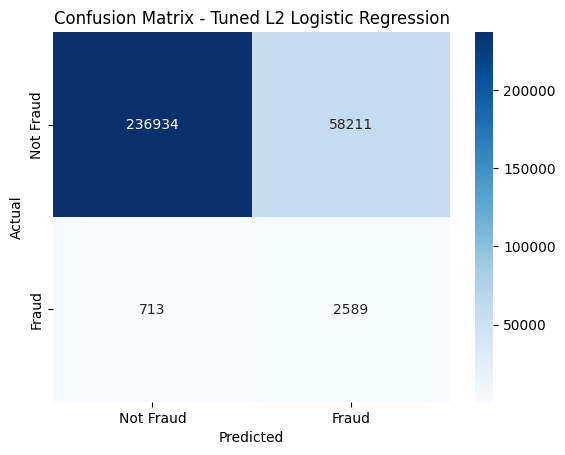

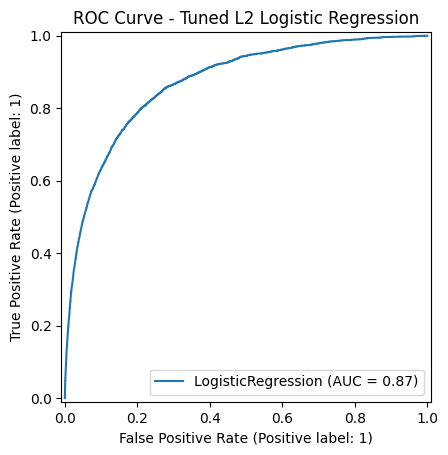

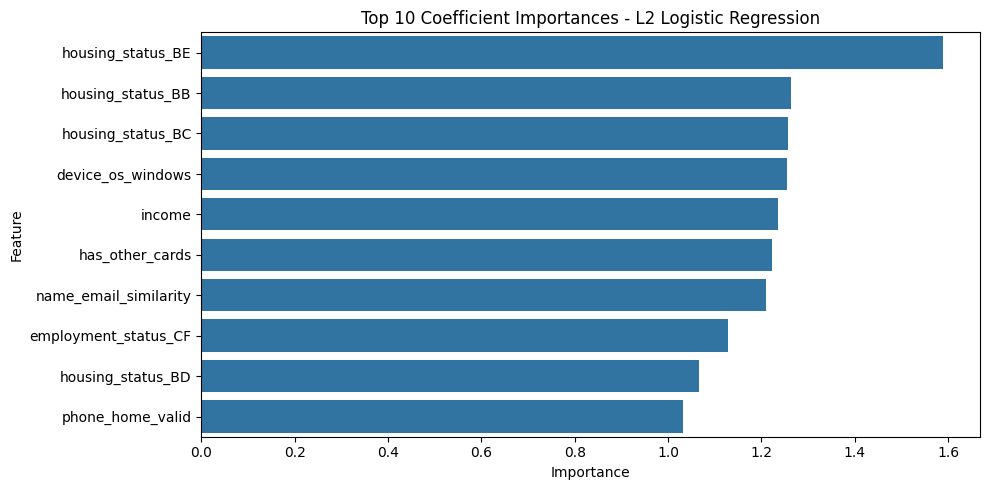

In [15]:

# Define Logistic Regression model (L2)
l2_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

# Hyperparameter grid (Ridge only)
param_grid_l2 = {
    'C': [0.01,0.05, 0.1, 1, 10],
    'max_iter': [1000, 2000, 3000]
}

# Cross-validation setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search for Logistic Regression (L2)
grid_l2 = GridSearchCV(
    estimator=l2_model,
    param_grid=param_grid_l2,
    scoring='recall',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

grid_l2.fit(X_train_balanced, y_train_balanced)

# Save best L2 model
best_l2_model = grid_l2.best_estimator_

# Save tuning results
l2_best_params = grid_l2.best_params_
l2_best_f2 = grid_l2.best_score_
l2_best_recall = recall_score(y_test, best_l2_model.predict(X_test))
l2_best_auc = roc_auc_score(y_test, best_l2_model.predict_proba(X_test)[:, 1])

print(" Best Parameters (L2):", l2_best_params)
print(" Best Recall at 1 (Test):", l2_best_recall)

# Evaluate on Test Set
y_pred_l2 = best_l2_model.predict(X_test)
y_proba_l2 = best_l2_model.predict_proba(X_test)[:, 1]

print("\n=== Tuned L2 Logistic Regression Evaluation ===")
print("Classification Report:\n", classification_report(y_test, y_pred_l2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_l2))
print("Accuracy:", accuracy_score(y_test, y_pred_l2))
print("ROC-AUC Score:", l2_best_auc)

# Confusion Matrix Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_l2), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - Tuned L2 Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_l2_model, X_test, y_test)
plt.title("ROC Curve - Tuned L2 Logistic Regression")
plt.show()

# Feature Importance (Top 10)
importance_l2 = np.abs(best_l2_model.coef_[0])
importance_l2_df = pd.DataFrame({'Feature': X_train_balanced.columns, 'Importance': importance_l2})
importance_l2_df.sort_values('Importance', ascending=False, inplace=True)

top_n = 10
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importance_l2_df.head(top_n))
plt.title(f"Top {top_n} Coefficient Importances - L2 Logistic Regression")
plt.tight_layout()
plt.show()

# Save results to results_df
results_df = pd.concat([
    results_df,
    pd.DataFrame({
        'Model': ['L2 Logistic Regression'],
        'Best Parameters': [l2_best_params],
        'Best ROC AUC': [l2_best_auc],
        'Best Recall at 1': [l2_best_recall]
    })
], ignore_index=True)


## Compare results among models

In [16]:
#Sort results by recall at 1 desceding
results_df_sorted = results_df.sort_values('Best Recall at 1', ascending=False)
print(results_df_sorted)

                      Model             Best Parameters Best ROC AUC  \
1    L1 Logistic Regression  {'C': 1, 'max_iter': 1000}     0.872248   
0  Base Logistic Regression                           -            -   
2    L2 Logistic Regression  {'C': 1, 'max_iter': 1000}     0.871919   

   Best Recall at 1  
1          0.785282  
0          0.784070  
2          0.784070  
